# SA score

Take all 100 sample generated molecules from guacamol benchmark => remove disconnected molecules => compute percentage of disconnected molecules + run through SA score


# Observations

1. AAE has better guacamol scores than VAE, particularly in the KL Div of the physiochemical properties and the FCD => indicating that the physiochemical properties are closer to that of the training set and the biological and chemical activities are likely to be closer to those of the training set => perhaps better for L1000 dataset since we are primarily concerned with the modelling of these properties in the context of drug molecules.
2. AAE => has more diconnected molecules (still valid smiles but incomplete given the max num steps) VAE has less disconnected molecules => 
3. AAE scores worse on SA scores => suggests that it is worse in terms of making sure the drugs are synthesizable.

In [3]:
import json

from rdkit import Chem
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer


In [4]:
parent_folder = '/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/distribution_learning_benchmark'

json_file_to_data = {}

for json_file in os.listdir(parent_folder):
    full_json_file_path = os.path.join(parent_folder, json_file)
    json_file_content = open(full_json_file_path)
    data = json.load(json_file_content)

    
    json_file_to_data[json_file] = data
    

In [10]:
from rdkit.Chem import Draw

tmp = {}

import matplotlib.pyplot as plt
for file_name, data in json_file_to_data.items():
    benchmark_scores = {}
    for benchmark in data['results']:
        name = benchmark['benchmark_name'].lower()
        score = benchmark['score']
        benchmark_scores[name] = score
    tmp[file_name] = benchmark_scores

    smiles = data['samples']

    smiles = [smile for smile in smiles if '.' not in smile]
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    
    pct_connected = len(smiles)/100
    tmp[file_name]['pct_connected'] = pct_connected
    
#     img = Draw.MolsToGridImage(mols[:24], subImgSize=(800,800), maxMols = 100, molsPerRow=8, returnPNG = True)
#     break
    # # #     img.save(f"/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/molecule_imgs/{file_name.strip('.json')}.svg")
#     with open(f"/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/molecule_imgs/{file_name.strip('.json')}.png", 'wb') as png:
#         png.write(img.data)
# img

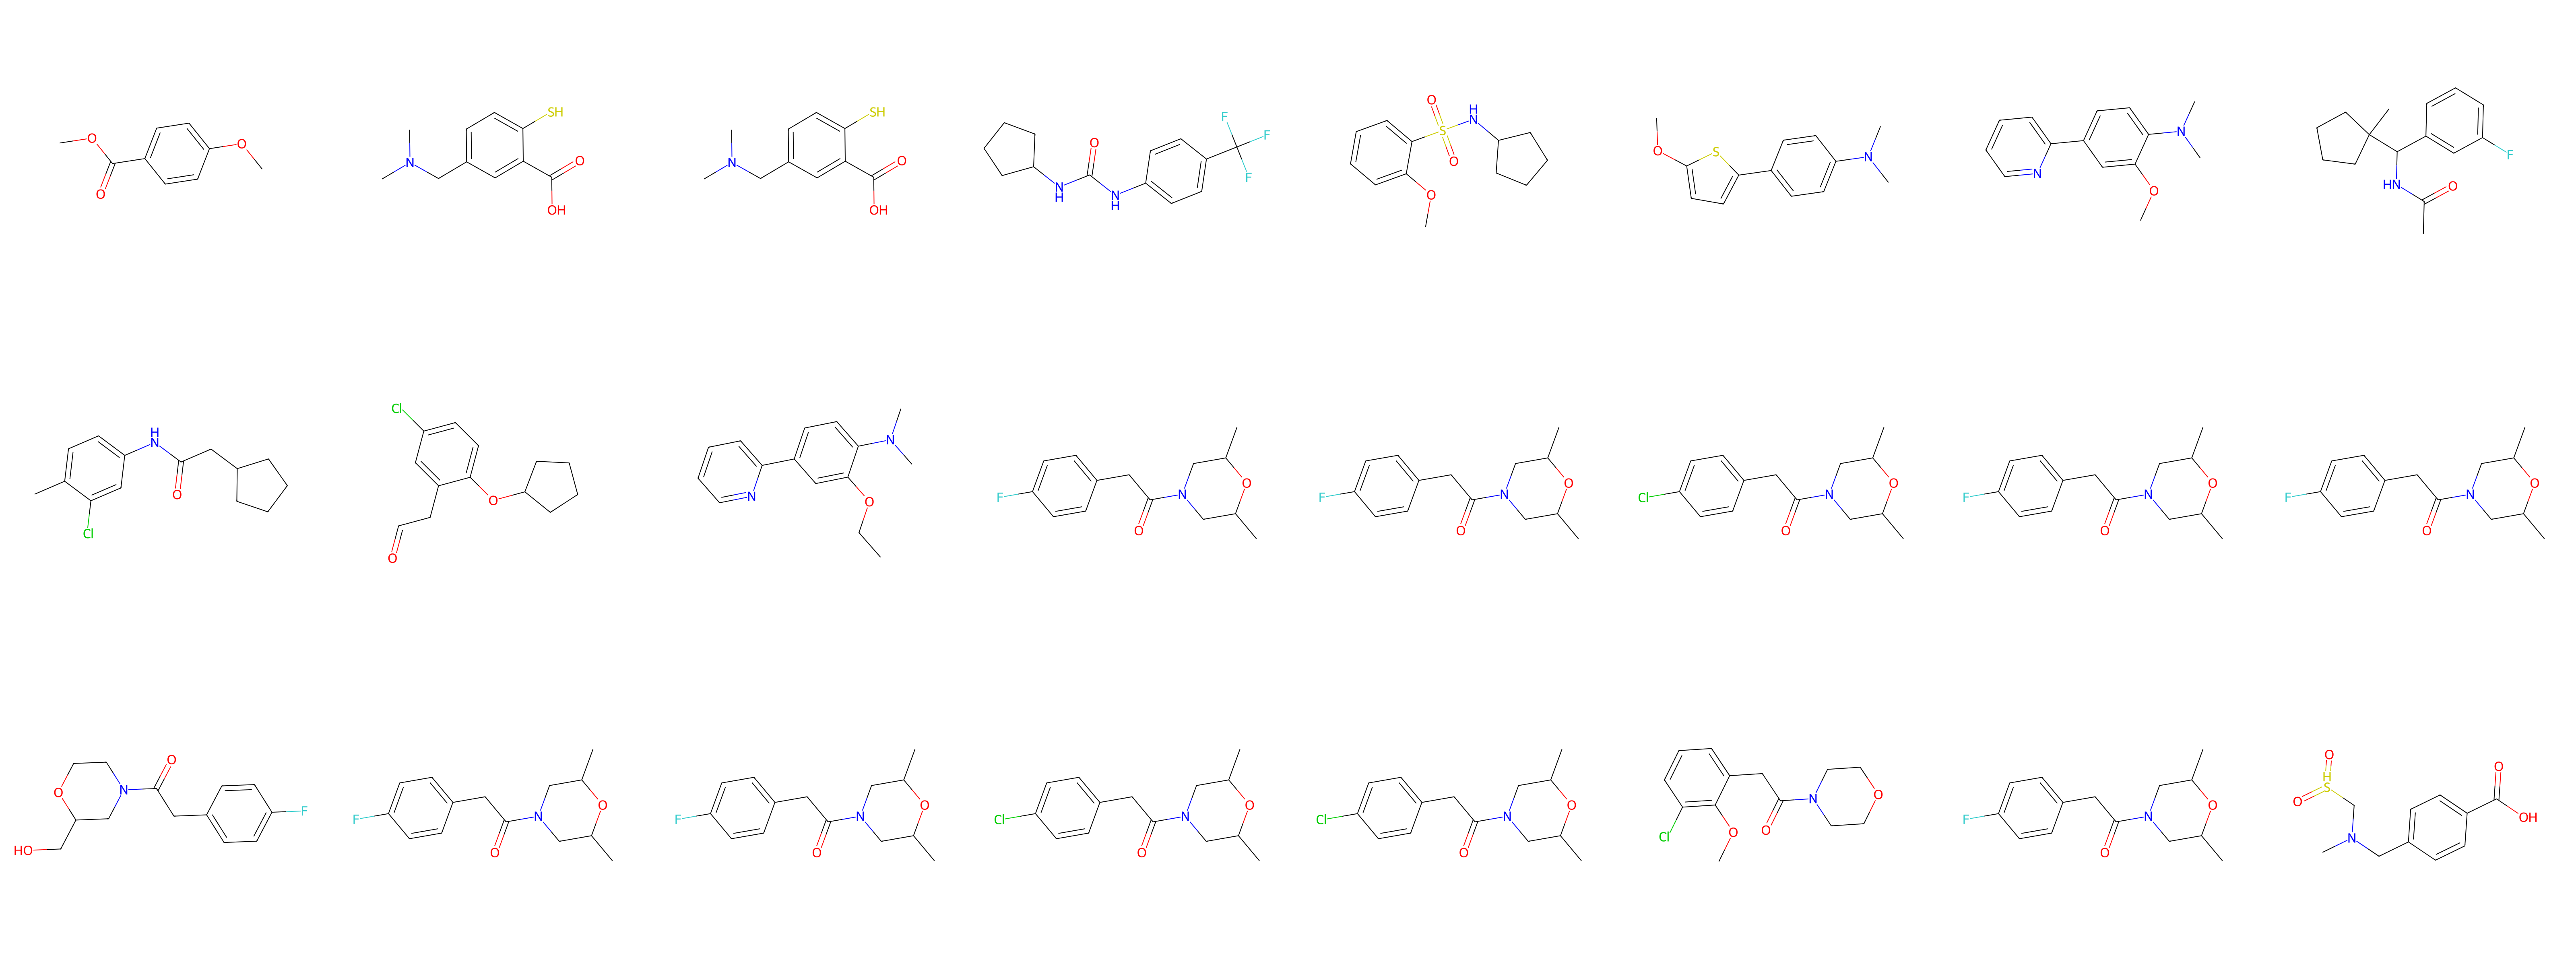

In [9]:
img

In [43]:
# plt.barh(*zip(*tmp['tl_l1000_wae_best_distribution_learning_results.json'].items()))
# plt.show()

<AxesSubplot: >

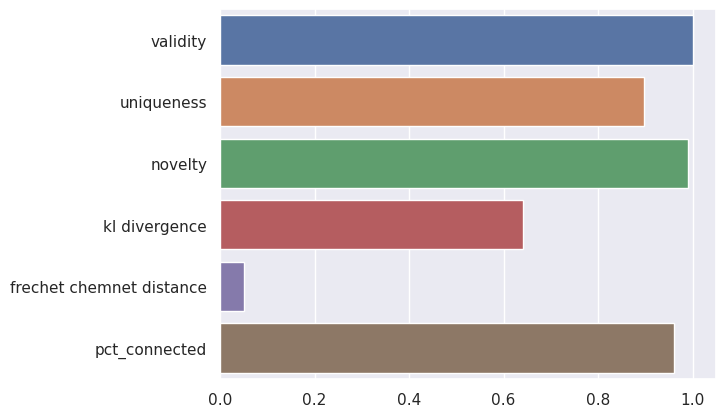

In [42]:
import seaborn as sns
sns.set_theme()
sns.barplot(
    y = list(tmp['tl_l1000_wae_best_distribution_learning_results.json'].keys()), 
    x = list(tmp['tl_l1000_wae_best_distribution_learning_results.json'].values()), 
    orient = 'h'
)

In [13]:
file_to_smiles = {file: result['samples'] for file, result in json_file_to_data.items()}
from rdkit.Chem.QED import qed

def compute_sa_score(mols, threshold = 4.5):
    
    sa_scores = [sascorer.calculateScore(mol) for mol in mols]
    pct_easily_synthesized = len([score for score in sa_scores if score <=4.5])/len(sa_scores)
    return sa_scores, pct_easily_synthesized

for file in file_to_smiles:
    mols = [Chem.MolFromSmiles(smile) for smile in file_to_smiles[file]]
    
    qed_scores = [qed(mol) for mol in mols]
    sa_scores, pct_easily_synthesized = compute_sa_score(mols)
    tmp[file]['sa_scores'] = sa_scores
    tmp[file]['pct_easily_synthesized'] = pct_easily_synthesized
    
    tmp[file]['qed_scores'] = qed_scores
    
    


In [16]:
import pandas as pd

# pd.DataFrame(tmp).T.to_csv('distribution_learning_with_pct_connected_sa_qed_scores.csv', index = False)

In [17]:
collated_results = pd.DataFrame(tmp).T

In [20]:
collated_results['avg'] = collated_results[['validity', 'uniqueness', 'novelty', 'kl divergence', 'frechet chemnet distance']].mean(axis=1)

In [22]:
collated_results.to_csv('guac_collated.csv', index = False)

In [ ]:
film_conv_distribution_learning_results_070223.json
wae_oclr_no_genstep_drop_ep5_distribution_learning_results.json
aae_oclr_genstep_drop_distribution_learning_results.json





In [58]:
import pandas as pd

df_results = pd.DataFrame(tmp).transpose()
for col in df_results.columns:
    df_results[col] = df_results[col].astype('float')

In [63]:
df_results['average_score'] = df_results.mean(axis=1)

In [64]:
df_results

,validity,uniqueness,novelty,kl divergence,frechet chemnet distance,average_score
aae_no_oclr_genstep_drop_distribution_learning_results.json,1.0,0.9979,0.9934,0.868493,0.266483,0.825255
aae_no_oclr_no_genstep_drop_eps8_distribution_learning_results.json,1.0,1.0000,0.9979,0.796869,0.349227,0.828799
aae_oclr_genstep_drop_distribution_learning_results.json,1.0,0.9999,0.9970,0.824105,0.331389,0.830479
film_conv_distribution_learning_results_070223.json,1.0,0.9549,0.9677,0.471463,0.087380,0.696289
gat_conv_distribution_learning_results_130223.json,1.0,0.8869,0.9581,0.420199,0.028582,0.658756
gcn_conv_distribution_learning_results_130223.json,1.0,0.8708,0.9668,0.474843,0.031737,0.668836
only_l1000_vae_distribution_learning_results.json,1.0,0.1927,0.3472,0.352732,0.003628,0.379252
tl_l1000_vae_no_oclr_distribution_learning_results.json,1.0,0.6851,0.9069,0.202130,0.008619,0.560550
vae_no_oclr_kl_anneal_genstep_drop_distribution_learning_results.json,1.0,0.9145,0.9576,0.426691,0.049629,0.669684
vae_oclr_kl_anneal_genstep_drop_distribution_learning_results.json,1.0,0.8241,0.9545,0.423511,0.037184,0.647859


### From the results, we see that:
##### VAE

1. GNN layer selection => from VAE runs (FiLMConv/GAT/GCNConv): FilMConv is the best GNN layer out of the 3
2. OCLR vs No OCLR => from VAE runs (both KL anneal): Not using OCLR is better; suggests that there is too much regularisation and it might not be suitable for VAE given the empirically observed training instability (model sporadically reaches NaN loss during the start of training when the weights of the model are randomly initialised). 
3. KL Anneal => from VAE runs: little to no difference, in fact slightly worse with KL anneal => don't use

Conclusion => No oclr + no kl anneal

Best model: FilMConv checkpoint from the beginning

##### AAE
1. Average distribution learning score is much higher than that of VAE
2. Gen step dropout: between the runs with no oclr, we see that gen step dropout is around the same => no point in using it, originally was supposed to save GPU memory due to smaller batch size but there is no point as it increases training time by alot since there is a need to rollout, dropout the gen steps randomly, then batch it again.
3. OCLR vs No OCLR: OCLR seems to be marginally better/the same => no point using it.

Conclusion => OCLR marginally better + no point using gen step dropout 

Best model: aae_oclr_genstep_drop

##### WAE
1. Average distribution learnign score is slightly higher than that of AAE
2. No gen step dropout for any of it because previously determined for AAE that it is no difference
3. Since OCLR was marginally better for aae, this was tested again for WAE => seems to be better
4. Gradient clipping wasn't used as gradient penalty was used instead; this is as stated in the original WGAN paper that GP is better than clipping

Conclusion => OCLR 

Best model: wae_oclr_no_genstep_drop_ep5




In [ ]:
with open("{}.png", "wb") as png:
    png.write(img.data)

In [ ]:
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(candidate_molecules, subImgSize=(200,200), maxMols = 1000, molsPerRow=10)
img

In [19]:
# Opening JSON file
f = open('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/distribution_learning_benchmark/wae_no_oclr_no_genstep_drop_ep8_distribution_learning_results.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

0.77


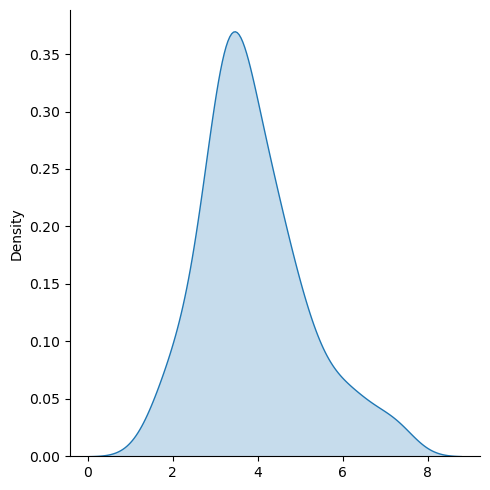

In [23]:
sa_scores, pct_easily_synthesized = compute_sa_score(data['samples'])
sns.displot(sa_scores, kind="kde", fill=True)
print(pct_easily_synthesized)

In [17]:
f = open("/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/distribution_learning_benchmark/film_conv_distribution_learning_results_070223.json")

data = json.load(f)

0.97


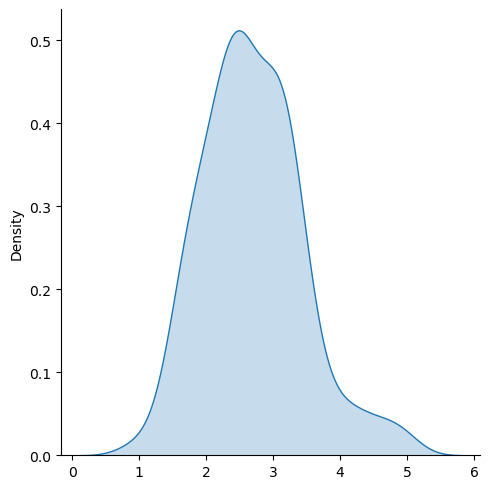

In [18]:
sa_scores, pct_easily_synthesized= compute_sa_score(data['samples'])
sns.displot(sa_scores, kind="kde", fill=True)
print(pct_easily_synthesized)

In [14]:
def compute_sa_score(smiles, threshold = 4.5):
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    sa_scores = [sascorer.calculateScore(mol) for mol in mols]
    pct_easily_synthesized = len([score for score in sa_scores if score <=4.5])/len(sa_scores)
    return sa_scores, pct_easily_synthesized

sa_scores, pct_easily_synthesized= compute_sa_score(data['samples'])

0.83


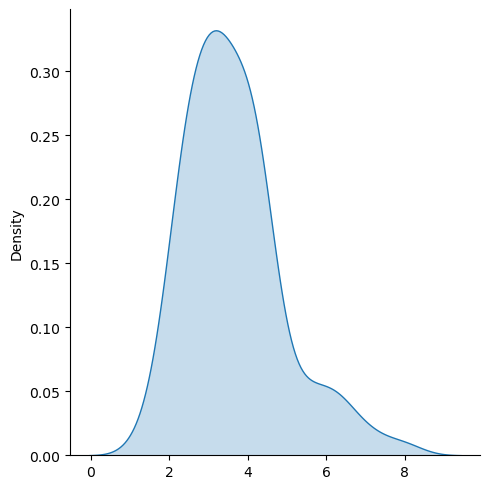

In [15]:
import seaborn as sns

sns.displot(sa_scores, kind="kde", fill=True)
print(pct_easily_synthesized)

# Test set rediscovery/Similarity search

1. Take L1000 test set's gene expressions 
2. For each pair of tumour and control gene expressions => compute a difference vector 
3. Use euclidean distance and cosine distance between difference vector and every other difference vector in train set
4. Choose the one with smallest distance (2 candidates per test set molecule)
5. Generate 10 * num_possible_difference_vectors molecules in total for the set of possible pairs in test set using gene expression (Model will get 10 tries per difference vector)
6. Compute max structural similarity between the generated molecules and their respective test set molecules 
7. Plot the distribution of max structural similarity for the similarity search and the max structural similarity for generated molecules (probability density plot)

### train validation test split must be such that test set doesn't have molecules in the train set: this is so that during similarity search, we don't want to get the exact same molecule


# Protein target (as per original paper)
1. Given a protein target, we want to find the known molecules that inhibit it AND also appear in the l1000 dataset (so that we have gene expressions for them) 
2. Given these gene expressions we can similarity search within the training set
3. Then we can compare these found molecules with ALL the known inhibitors for that protein

### train validation test split will be based on which of the molecules are in the Excape database => all those belonging to the protein targets will have to be in the test set and not in the train set

In [52]:
known_dataset.ControlIndices.values[0]



'[12373 12374 12375 12376 12377 12378 12379 12380 12381 12382 12383 12384\n 12385 12386 12387 12388 12389 12390 12391 12392 12393 12394 12395 12396\n 12397 12398 12399 12400 12401 12402 12403]'

### Similarity search using test set

In [6]:
import pandas as pd
from scipy.spatial.distance import cosine, euclidean
import ast
train_set = pd.read_csv("/data/ongh0068/l1000/l1000_biaae/INPUT_DIR/train.csv")
valid_set = pd.read_csv("/data/ongh0068/l1000/l1000_biaae/INPUT_DIR/valid.csv")


known_dataset = pd.concat([train_set, valid_set])
# known_dataset = known_dataset.replace({'\n': ''}, regex=True)
def sanitise(row):
    """Specifically for the L1000 csv"""
    control_indices = row["ControlIndices"].replace('[', '').replace(']', '').replace('\n', '').split(" ")
    control_indices = [idx for idx in control_indices if idx != '']
    row["ControlIndices"] = np.asarray(control_indices, dtype=np.int32)
    tumour_indices = row["TumourIndices"].replace('[', '').replace(']', '').replace('\n', '').split(" ")
    tumour_indices = [idx for idx in tumour_indices if idx != '']    
    row["TumourIndices"] = np.asarray(tumour_indices, dtype=np.int32)
    return row



known_dataset = known_dataset.apply(lambda x: sanitise(x), axis = 1)

test_set = pd.read_csv("/data/ongh0068/l1000/l1000_biaae/INPUT_DIR/test.csv")
test_set = test_set.apply(lambda x: sanitise(x), axis = 1)


In [7]:
known_dataset

,Unnamed: 0,CellLine,Time,Dose,ControlIndices,TumourIndices,SMILES,DrugIndex_maccs,DrugIndex_pharmacophore2d720,DrugIndex_morgan,...,primary_site_large intestine,primary_site_liver,primary_site_lung,primary_site_muscle,primary_site_ovary,primary_site_prostate,primary_site_skin,primary_site_stomach,primary_site_unknown,original_idx
0,0,A375,6.0,10.00,"[12373, 12374, 12375, 12376, 12377, 12378, 123...","[343818, 343819, 343820]",CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,...,0,0,0,0,0,0,1,0,0,0
1,1,A549,6.0,10.00,"[12471, 12472, 12473, 12474, 12475, 12476, 124...","[346328, 346329]",CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,...,0,0,1,0,0,0,0,0,0,1
2,2,A549,24.0,10.00,"[12529, 12530, 12531, 12532, 12533, 12534, 125...","[349439, 349440, 349441]",CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,...,0,0,1,0,0,0,0,0,0,2
3,3,ASC,24.0,10.00,"[12626, 12627, 12628, 12629, 12630, 12631, 126...","[352969, 352970, 352971, 352972]",CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,...,0,0,0,0,0,0,0,0,0,3
4,4,HA1E,6.0,10.00,"[3875, 3876, 3877, 3878, 3879, 3880, 3881, 388...","[82857, 82858]",CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22342,187021,VCAP,24.0,5.02,"[17239, 17240, 17241, 17242, 17243, 17244, 172...","[475267, 475268, 475269]",CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)N(C)C)C2N1CCc1...,6670,4418,6386,...,0,0,0,0,0,1,0,0,0,99293
22343,187032,VCAP,6.0,5.02,"[18703, 18704, 18705, 18706, 18707, 18708, 187...","[467700, 467701, 467702]",CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCc3ccc(F)cc3)...,2305,5971,9035,...,0,0,0,0,0,1,0,0,0,99304
22344,187033,VCAP,24.0,5.02,"[17239, 17240, 17241, 17242, 17243, 17244, 172...","[475291, 475292, 475293]",CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCc3ccc(F)cc3)...,2305,5971,9035,...,0,0,0,0,0,1,0,0,0,99305
22345,187034,VCAP,6.0,4.99,"[18703, 18704, 18705, 18706, 18707, 18708, 187...","[467703, 467704, 467705]",CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCc3cc(F)cc(F)...,6919,4096,968,...,0,0,0,0,0,1,0,0,0,99306


In [8]:
from dataset import LincsDataset

dataset = LincsDataset(
    root = '/data/ongh0068', 
    raw_moler_trace_dataset_parent_folder = '/data/ongh0068/guacamol/trace_dir',
    output_pyg_trace_dataset_parent_folder = '/data/ongh0068/l1000/l1000_biaae/already_batched',
    split = 'valid_0',
    gene_exp_controls_file_path = '/data/ongh0068/l1000/l1000_biaae/lincs/robust_normalized_controls.npz',
    gene_exp_tumour_file_path = '/data/ongh0068/l1000/l1000_biaae/lincs/robust_normalized_tumors.npz',
    lincs_csv_file_path = '/data/ongh0068/l1000/l1000_biaae/lincs/experiments_filtered.csv',
)

Loading controls gene expression...
Loading tumour gene expression...
Loading csv...


In [137]:
# For the training set, for each row, we compute the batched numpy array of difference vectors => then we use 
# the batched possible difference vectors to compute the nearest difference vector to the difference vectors in the test set

import itertools  
from tqdm import tqdm 
def compute_possible_difference_vectors(
    sample_control_idx, 
    sample_tumour_idx,
    dataset,
):
    possible_pairs = np.array(list(itertools.product(sample_control_idx, sample_tumour_idx)))

    control_idx_batched = possible_pairs[:, 0]
    tumour_idx_batched = possible_pairs[:, 1]

    control_gene_exp_batched = dataset._gene_exp_controls[control_idx_batched]
    tumour_gene_exp_batched = dataset._gene_exp_tumour[tumour_idx_batched]
    difference_gene_exp_batched = tumour_gene_exp_batched - control_gene_exp_batched
    difference_gene_exp_batched_mean = difference_gene_exp_batched.mean(0)

    return difference_gene_exp_batched_mean

reference_smiles = known_dataset.SMILES.to_list()
control_idxes = known_dataset.ControlIndices.values
tumour_idxes = known_dataset.TumourIndices.values
original_idxes = known_dataset.original_idx
known_dataset_smiles_to_diff_vectors = {} # key = smiles; values = batched difference vector
for control_idx, tumour_idx, smile, original_idx in tqdm(zip(control_idxes, tumour_idxes, reference_smiles, original_idxes)):
    batched_difference_vectors = compute_possible_difference_vectors(
        control_idx, 
        tumour_idx,
        dataset,
    )

    known_dataset_smiles_to_diff_vectors['_'.join([smile, str(original_idx)])] = batched_difference_vectors


91033it [01:26, 1055.11it/s]


In [166]:
tmp_diff_vectors =[]
ordered_keys = []
for key, value in known_dataset_smiles_to_diff_vectors.items():
    tmp_diff_vectors.append(value)
    ordered_keys.append(key)

known_dataset_avg_diff_vector = np.vstack(tmp_diff_vectors)


['CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_0',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_1',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_2',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_3',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_4',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_5',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_6',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_7',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_8',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_9',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_10',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_11',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_12',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_13',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_14',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_15',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_16',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_17',
 'CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1_18',
 'CCCCC#Cc1nc(NC)c2ncn(C3OC(CO)C(O)C3O)c2n1_19',
 'CCCCC#Cc1nc(NC)c2ncn(C3OC(CO

In [141]:
# For each possible tumour-control gene expression, we compute a difference vector and find the closest 
reference_smiles = test_set.SMILES.to_list()
control_idxes = test_set.ControlIndices.values
tumour_idxes = test_set.TumourIndices.values
original_idxes = known_dataset.original_idx
test_set_smiles_to_diff_vectors = {} # key = smiles; values = batched difference vector
for control_idx, tumour_idx, smile, original_idx in tqdm(zip(control_idxes, tumour_idxes, reference_smiles, original_idxes)):
    batched_difference_vectors = compute_possible_difference_vectors(
        control_idx, 
        tumour_idx,
        dataset,
    )
    test_set_smiles_to_diff_vectors['_'.join([smile, str(original_idx)])] = batched_difference_vectors


8281it [00:09, 919.62it/s] 


In [209]:
from tqdm import tqdm

# test_set_smiles_to_train_set_diff_vector_and_distance = {}
"""

{
    test_set_smile:{
        train_set_smile: {
            'euclidean_dist': ___,
            'cosine_dist': ___,
        }
    }
}

"""



    
for test_set_smile in tqdm(test_set_smiles_to_diff_vectors):
    test_set_candidate = test_set_smiles_to_diff_vectors[test_set_smile]
    
#     batched_euclidean_dist = np.linalg.norm(known_dataset_avg_diff_vector- test_set_candidate, axis = 1)
#     min_euclidean_dist = batched_euclidean_dist.min()
#     smile_corresp_min_euclidean_dist = ordered_keys[np.argmin(batched_euclidean_dist)]
    
    batched_cosine_sim = np.dot(known_dataset_avg_diff_vector,test_set_candidate)/(np.linalg.norm(repeated_train_set_candidate)*np.linalg.norm(repeated_test_set_candidate))
    max_cosine_sim = batched_cosine_sim.max()
    smile_corresp_max_cosine_sim = ordered_keys[np.argmax(batched_cosine_sim)]
    
#     test_set_smiles_to_train_set_diff_vector_and_distance[test_set_smile] = {
#         'min_euclidean_dist': {
#             'smile': smile_corresp_min_euclidean_dist,
#             'dist': min_euclidean_dist
#         },
#         'max_cosine_sim':{
#             'smile': smile_corresp_max_cosine_sim,
#             'dist': max_cosine_sim
#         }
#     }
    
    test_set_smiles_to_train_set_diff_vector_and_distance[test_set_smile]['max_cosine_sim'] = {
        'smile': smile_corresp_max_cosine_sim,
        'dist': max_cosine_sim  
    }


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8281/8281 [03:36<00:00, 38.23it/s]


In [210]:
test_set_smiles_to_train_set_diff_vector_and_distance

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_0': {'min_euclidean_dist': {'smile': 'CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C_4356',
   'dist': 7.569423},
  'min_cosine_sim': {'smile': 'CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)cc32)c1C_51119',
   'dist': -4.50906e-06},
  'max_cosine_sim': {'smile': 'COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1_58004',
   'dist': 2.869751e-06}},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_1': {'min_euclidean_dist': {'smile': 'CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1_10031',
   'dist': 6.8265467},
  'min_cosine_sim': {'smile': 'CC(=O)C(C#N)C(=O)Nc1cc(Br)ccc1Br_3570',
   'dist': -1.1796407e-06},
  'max_cosine_sim': {'smile': 'OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1_21393',
   'dist': 1.384695e-06}},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_2': {'min_euclidean_dist': {'smile': 'CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O_37665',
   'dist': 7.199553},
  'min_cosine_sim': {'smile': 'CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)cc32)c1C_511

In [218]:
import pickle
with open('test_set_sim_search.pkl', 'wb')as f:
    pickle.dump(test_set_smiles_to_train_set_diff_vector_and_distance, f)

#### Compute 3 similarities based on candidates selected using euclidean_distance and cosine distance

In [236]:
# def compute_max_similarity(
#     candidate_molecules, 
#     reference_smile, 
#     radius = 3,
#     nBits = 1024
# ):
#     m_fps = [AllChem.GetMorganFingerprintAsBitVect(mol,radius=radius, nBits=nBits) for mol in candidate_molecules]
#     maccs_fps = [MACCSkeys.GenMACCSKeys(mol) for mol in candidate_molecules]
#     reference_mol = Chem.MolFromSmiles(reference_smile)
#     reference_smile_m_fp =  AllChem.GetMorganFingerprintAsBitVect(reference_mol,radius=radius, nBits=nBits) 
#     reference_smile_maccs_fp = MACCSkeys.GenMACCSKeys(reference_mol)


#     m_fp_tanimoto_sim = DataStructs.BulkTanimotoSimilarity(reference_smile_m_fp, m_fps)
#     maccs_fp_tanimoto_sim = DataStructs.BulkTanimotoSimilarity(reference_smile_maccs_fp, maccs_fps)
#     fraggle_sims = [sim for sim, match in [GetFraggleSimilarity(reference_mol,candidate_mol) for candidate_mol in candidate_molecules]]
#     return {
#         'max_morgan_fp_tanimoto_sim': max(m_fp_tanimoto_sim),
#         'max_maccs_fp_tanimoto_sim': max(maccs_fp_tanimoto_sim),
#         'max_fraggle_sim': max(fraggle_sims)
#     }

from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem.Fraggle.FraggleSim import GetFraggleSimilarity
from rdkit import Chem
from tqdm import tqdm

eu_dist_similarities = {
    'm_fp_tanimoto_sim':[],
    'maccs_fp_tanimoto_sim':[],
    'fraggle_sims':[]
}

cosine_dist_similarities = {
    'm_fp_tanimoto_sim':[],
    'maccs_fp_tanimoto_sim':[],
    'fraggle_sims':[]
}


radius = 3
nBits = 1024

for test_set_smile_idx in tqdm(test_set_smiles_to_train_set_diff_vector_and_distance):
    try:
        test_set_smile = ''.join(test_set_smile_idx.rsplit('_', 1)[0])
        test_set_mol = Chem.MolFromSmiles(test_set_smile)

        test_set_smile_m_fp =  AllChem.GetMorganFingerprintAsBitVect(test_set_mol,radius=radius, nBits=nBits) 
        test_set_smile_maccs_fp = MACCSkeys.GenMACCSKeys(test_set_mol)

        eu_dist_smile = test_set_smiles_to_train_set_diff_vector_and_distance[test_set_smile_idx]['min_euclidean_dist']['smile'].rsplit('_', 1)[0]
        eu_dist_mol = Chem.MolFromSmiles(eu_dist_smile)

        eu_dist_smile_m_fp =  AllChem.GetMorganFingerprintAsBitVect(eu_dist_mol,radius=radius, nBits=nBits) 
        eu_dist_smile_maccs_fp = MACCSkeys.GenMACCSKeys(eu_dist_mol)

        m_fp_tanimoto_sim = DataStructs.TanimotoSimilarity(test_set_smile_m_fp, eu_dist_smile_m_fp)
        maccs_fp_tanimoto_sim = DataStructs.TanimotoSimilarity(test_set_smile_maccs_fp, eu_dist_smile_maccs_fp)
        fraggle_sim, match = GetFraggleSimilarity(test_set_mol,eu_dist_mol)

        eu_dist_similarities['m_fp_tanimoto_sim'].append(m_fp_tanimoto_sim)
        eu_dist_similarities['maccs_fp_tanimoto_sim'].append(maccs_fp_tanimoto_sim)
        eu_dist_similarities['fraggle_sims'].append(fraggle_sim)

        # Cosine distance
        cos_dist_smile = test_set_smiles_to_train_set_diff_vector_and_distance[test_set_smile_idx]['max_cosine_sim']['smile'].rsplit('_', 1)[0]
        cos_dist_mol = Chem.MolFromSmiles(cos_dist_smile)

        cos_dist_smile_m_fp =  AllChem.GetMorganFingerprintAsBitVect(cos_dist_mol,radius=radius, nBits=nBits) 
        cos_dist_smile_maccs_fp = MACCSkeys.GenMACCSKeys(cos_dist_mol)

        m_fp_tanimoto_sim = DataStructs.TanimotoSimilarity(test_set_smile_m_fp, cos_dist_smile_m_fp)
        maccs_fp_tanimoto_sim = DataStructs.TanimotoSimilarity(test_set_smile_maccs_fp, cos_dist_smile_maccs_fp)
        fraggle_sim, match = GetFraggleSimilarity(test_set_mol,cos_dist_mol)

        cosine_dist_similarities['m_fp_tanimoto_sim'].append(m_fp_tanimoto_sim)
        cosine_dist_similarities['maccs_fp_tanimoto_sim'].append(maccs_fp_tanimoto_sim)
        cosine_dist_similarities['fraggle_sims'].append(fraggle_sim)

    except Exception as e:
        print(e)

  2%|██▎                                                                                                                                                     | 126/8281 [00:45<31:39,  4.29it/s][16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
[16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
  2%|██▎                                                                                                                                                     | 128/8281 [00:45<20:38,  6.59it/s][16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
[16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
  2%|██▍                                                                                                                                                     | 130/8281 [00:45<15:08,  8.98it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
[16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
  2%|██▍                                                                                                                                                     | 132/8281 [00:45<12:29, 10.87it/s][16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
[16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
  2%|██▍                                                                                                                                                     | 134/8281 [00:45<10:44, 12.64it/s][16:15:39] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
  2%|██▍                                                                                                                                                     | 136/8281 [00:45<09:28, 14.34it/s][16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
[16:15:39] Can't kekulize mol.  Unkekulized atoms: 12
  2%|██▌                                                                                                                                                     | 138/8281 [00:45<08:48, 15.40it/s][16:15:39] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

  3%|████▉                                                                                                                                                   | 266/8281 [00:54<09:11, 14.53it/s][16:15:48] Can't kekulize mol.  Unkekulized atoms: 1
[16:15:48] Can't kekulize mol.  Unkekulized atoms: 1
[16:15:48] Can't kekulize mol.  Unkekulized atoms: 1
  3%|████▉                                                                                                                                                   | 269/8281 [00:54<08:02, 16.61it/s][16:15:48] Can't kekulize mol.  Unkekulized atoms: 1


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:48] Can't kekulize mol.  Unkekulized atoms: 1
[16:15:48] Can't kekulize mol.  Unkekulized atoms: 1
  3%|████▉                                                                                                                                                   | 272/8281 [00:54<07:26, 17.94it/s][16:15:48] Can't kekulize mol.  Unkekulized atoms: 1
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1
  3%|█████                                                                                                                                                   | 275/8281 [00:55<07:04, 18.88it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1
  3%|█████                                                                                                                                                   | 277/8281 [00:55<06:58, 19.11it/s][16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  3%|█████▏                                                                                                                                                  | 281/8281 [00:55<05:54, 22.59it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  3%|█████▏                                                                                                                                                  | 285/8281 [00:55<05:09, 25.79it/s][16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  3%|█████▎                                                                                                                                                  | 288/8281 [00:55<05:04, 26.27it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|█████▎                                                                                                                                                  | 291/8281 [00:55<04:54, 27.14it/s][16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|█████▍                                                                                                                                                  | 295/8281 [00:55<04:42, 28.25it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|█████▍                                                                                                                                                  | 298/8281 [00:55<04:38, 28.66it/s][16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:49] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|█████▌                                                                                                                                                  | 302/8281 [00:55<04:28, 29.73it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|█████▌                                                                                                                                                  | 305/8281 [00:56<04:30, 29.46it/s][16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|█████▋                                                                                                                                                  | 308/8281 [00:56<04:39, 28.51it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|█████▋                                                                                                                                                  | 311/8281 [00:56<04:38, 28.65it/s][16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|█████▊                                                                                                                                                  | 315/8281 [00:56<04:24, 30.16it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|█████▊                                                                                                                                                  | 319/8281 [00:56<04:19, 30.70it/s][16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|█████▉                                                                                                                                                  | 323/8281 [00:56<04:22, 30.28it/s][16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|██████                                                                                                                                                  | 327/8281 [00:56<04:31, 29.31it/s][16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|██████                                                                                                                                                  | 330/8281 [00:56<04:32, 29.22it/s][16:15:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|██████                                                                                                                                                  | 333/8281 [00:57<04:35, 28.85it/s][16:15:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:15:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|██████▏                                                                                                                                                 | 336/8281 [00:57<04:42, 28.17it/s][16:15:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  4%|██████▏                                                                                                                                                 | 339/8281 [00:57<04:43, 27.99it/s][16:15:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
[16:15:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

  5%|███████▋                                                                                                                                                | 418/8281 [01:15<35:52,  3.65it/s][16:16:09] non-ring atom 20 marked aromatic
[16:16:09] non-ring atom 20 marked aromatic
  5%|███████▋                                                                                                                                                | 420/8281 [01:15<22:50,  5.74it/s][16:16:09] non-ring atom 20 marked aromatic
[16:16:09] non-ring atom 20 marked aromatic
  5%|███████▋                                                                                                                                                | 422/8281 [01:15<16:55,  7.74it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:10] non-ring atom 20 marked aromatic
[16:16:10] non-ring atom 20 marked aromatic
  5%|███████▊                                                                                                                                                | 424/8281 [01:16<13:33,  9.66it/s][16:16:10] non-ring atom 20 marked aromatic
[16:16:10] non-ring atom 20 marked aromatic
  5%|███████▊                                                                                                                                                | 426/8281 [01:16<11:37, 11.26it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:10] non-ring atom 20 marked aromatic
[16:16:10] non-ring atom 20 marked aromatic
  5%|███████▊                                                                                                                                                | 428/8281 [01:16<10:29, 12.47it/s][16:16:10] non-ring atom 20 marked aromatic
[16:16:10] non-ring atom 20 marked aromatic
  5%|███████▉                                                                                                                                                | 430/8281 [01:16<09:37, 13.59it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:10] non-ring atom 20 marked aromatic
[16:16:10] non-ring atom 20 marked aromatic
  5%|███████▉                                                                                                                                                | 432/8281 [01:16<09:06, 14.35it/s][16:16:10] non-ring atom 20 marked aromatic
[16:16:10] non-ring atom 20 marked aromatic
  5%|███████▉                                                                                                                                                | 434/8281 [01:16<08:28, 15.44it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:10] non-ring atom 20 marked aromatic
[16:16:10] non-ring atom 20 marked aromatic
  5%|████████                                                                                                                                                | 436/8281 [01:16<07:54, 16.54it/s][16:16:10] non-ring atom 20 marked aromatic
[16:16:10] non-ring atom 20 marked aromatic
  5%|████████                                                                                                                                                | 438/8281 [01:16<07:42, 16.94it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:10] non-ring atom 20 marked aromatic
[16:16:10] non-ring atom 20 marked aromatic
  5%|████████                                                                                                                                                | 440/8281 [01:17<07:30, 17.40it/s][16:16:11] non-ring atom 20 marked aromatic
[16:16:11] non-ring atom 20 marked aromatic
  5%|████████                                                                                                                                                | 442/8281 [01:17<07:21, 17.75it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:11] non-ring atom 20 marked aromatic
[16:16:11] non-ring atom 20 marked aromatic
  5%|████████▏                                                                                                                                               | 444/8281 [01:17<07:24, 17.64it/s][16:16:11] non-ring atom 20 marked aromatic
[16:16:11] non-ring atom 20 marked aromatic
  5%|████████▏                                                                                                                                               | 446/8281 [01:17<07:18, 17.88it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:11] non-ring atom 20 marked aromatic
[16:16:11] non-ring atom 20 marked aromatic
  5%|████████▏                                                                                                                                               | 448/8281 [01:17<07:20, 17.76it/s][16:16:11] non-ring atom 20 marked aromatic
[16:16:11] non-ring atom 20 marked aromatic
  5%|████████▎                                                                                                                                               | 450/8281 [01:17<07:21, 17.76it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:11] non-ring atom 20 marked aromatic
[16:16:11] non-ring atom 20 marked aromatic
  5%|████████▎                                                                                                                                               | 452/8281 [01:17<07:15, 17.97it/s][16:16:11] non-ring atom 20 marked aromatic
[16:16:11] non-ring atom 20 marked aromatic
  5%|████████▎                                                                                                                                               | 454/8281 [01:17<07:11, 18.13it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:11] non-ring atom 20 marked aromatic
[16:16:11] non-ring atom 20 marked aromatic
  6%|████████▎                                                                                                                                               | 456/8281 [01:17<07:18, 17.83it/s][16:16:11] non-ring atom 20 marked aromatic
[16:16:11] non-ring atom 20 marked aromatic
  6%|████████▍                                                                                                                                               | 458/8281 [01:17<07:13, 18.06it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:12] non-ring atom 20 marked aromatic
[16:16:12] non-ring atom 20 marked aromatic
  6%|████████▍                                                                                                                                               | 460/8281 [01:18<07:15, 17.97it/s][16:16:12] non-ring atom 20 marked aromatic
[16:16:12] non-ring atom 20 marked aromatic
  6%|████████▍                                                                                                                                               | 462/8281 [01:18<07:14, 18.01it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:12] non-ring atom 20 marked aromatic
[16:16:12] non-ring atom 20 marked aromatic
  6%|████████▌                                                                                                                                               | 464/8281 [01:18<07:13, 18.02it/s][16:16:12] non-ring atom 20 marked aromatic
[16:16:12] non-ring atom 20 marked aromatic
  6%|████████▌                                                                                                                                               | 466/8281 [01:18<07:17, 17.85it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:12] non-ring atom 20 marked aromatic
[16:16:12] non-ring atom 20 marked aromatic
  6%|████████▌                                                                                                                                               | 468/8281 [01:18<07:23, 17.61it/s][16:16:12] non-ring atom 20 marked aromatic
[16:16:12] non-ring atom 20 marked aromatic
  6%|████████▋                                                                                                                                               | 470/8281 [01:18<07:25, 17.52it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:12] non-ring atom 20 marked aromatic
[16:16:12] non-ring atom 20 marked aromatic
  6%|████████▋                                                                                                                                               | 472/8281 [01:18<07:37, 17.06it/s][16:16:12] non-ring atom 20 marked aromatic
[16:16:12] non-ring atom 20 marked aromatic
  6%|████████▋                                                                                                                                               | 474/8281 [01:18<07:41, 16.93it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:12] non-ring atom 20 marked aromatic
[16:16:13] non-ring atom 20 marked aromatic
  6%|████████▋                                                                                                                                               | 476/8281 [01:19<07:46, 16.74it/s][16:16:13] non-ring atom 20 marked aromatic
[16:16:13] non-ring atom 20 marked aromatic
  6%|████████▊                                                                                                                                               | 478/8281 [01:19<07:48, 16.66it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:13] non-ring atom 20 marked aromatic
[16:16:13] non-ring atom 20 marked aromatic
  6%|████████▊                                                                                                                                               | 480/8281 [01:19<07:54, 16.43it/s][16:16:13] non-ring atom 20 marked aromatic
[16:16:13] non-ring atom 20 marked aromatic
  6%|████████▊                                                                                                                                               | 482/8281 [01:19<07:53, 16.47it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:13] non-ring atom 20 marked aromatic
[16:16:13] non-ring atom 20 marked aromatic
  6%|████████▉                                                                                                                                               | 484/8281 [01:19<07:55, 16.40it/s][16:16:13] non-ring atom 20 marked aromatic
[16:16:13] non-ring atom 20 marked aromatic
  6%|████████▉                                                                                                                                               | 486/8281 [01:19<07:57, 16.34it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:13] non-ring atom 20 marked aromatic
[16:16:13] non-ring atom 20 marked aromatic
  6%|████████▉                                                                                                                                               | 488/8281 [01:19<08:05, 16.04it/s][16:16:13] non-ring atom 20 marked aromatic
[16:16:13] non-ring atom 20 marked aromatic
  6%|████████▉                                                                                                                                               | 490/8281 [01:19<07:46, 16.72it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:13] non-ring atom 20 marked aromatic
[16:16:14] non-ring atom 20 marked aromatic
  6%|█████████                                                                                                                                               | 492/8281 [01:20<07:31, 17.26it/s][16:16:14] non-ring atom 20 marked aromatic
[16:16:14] non-ring atom 20 marked aromatic
  6%|█████████                                                                                                                                               | 494/8281 [01:20<07:26, 17.43it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:14] non-ring atom 20 marked aromatic
[16:16:14] non-ring atom 20 marked aromatic
  6%|█████████                                                                                                                                               | 496/8281 [01:20<07:19, 17.72it/s][16:16:14] non-ring atom 20 marked aromatic
[16:16:14] non-ring atom 20 marked aromatic
  6%|█████████▏                                                                                                                                              | 498/8281 [01:20<07:14, 17.90it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:14] non-ring atom 20 marked aromatic
[16:16:14] non-ring atom 20 marked aromatic
  6%|█████████▏                                                                                                                                              | 500/8281 [01:20<07:07, 18.22it/s][16:16:14] non-ring atom 20 marked aromatic
[16:16:14] non-ring atom 20 marked aromatic
  6%|█████████▏                                                                                                                                              | 502/8281 [01:20<07:05, 18.30it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:14] non-ring atom 20 marked aromatic
[16:16:14] non-ring atom 20 marked aromatic
  6%|█████████▎                                                                                                                                              | 504/8281 [01:20<07:03, 18.35it/s][16:16:14] non-ring atom 20 marked aromatic
[16:16:14] non-ring atom 20 marked aromatic
  6%|█████████▎                                                                                                                                              | 506/8281 [01:20<07:01, 18.45it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:14] non-ring atom 20 marked aromatic
[16:16:14] non-ring atom 20 marked aromatic
  6%|█████████▎                                                                                                                                              | 508/8281 [01:20<07:01, 18.46it/s][16:16:14] non-ring atom 20 marked aromatic


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

  8%|████████████▊                                                                                                                                           | 700/8281 [01:52<50:08,  2.52it/s][16:16:46] Can't kekulize mol.  Unkekulized atoms: 1
[16:16:46] Can't kekulize mol.  Unkekulized atoms: 1
  8%|████████████▉                                                                                                                                           | 702/8281 [01:52<30:43,  4.11it/s][16:16:46] Can't kekulize mol.  Unkekulized atoms: 1
[16:16:46] Can't kekulize mol.  Unkekulized atoms: 1
  9%|████████████▉                                                                                                                                           | 704/8281 [01:52<21:24,  5.90it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:47] Can't kekulize mol.  Unkekulized atoms: 1
[16:16:47] Can't kekulize mol.  Unkekulized atoms: 1
  9%|████████████▉                                                                                                                                           | 706/8281 [01:53<16:13,  7.78it/s][16:16:47] Can't kekulize mol.  Unkekulized atoms: 1
[16:16:47] Can't kekulize mol.  Unkekulized atoms: 1
  9%|████████████▉                                                                                                                                           | 708/8281 [01:53<13:35,  9.28it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:16:47] Can't kekulize mol.  Unkekulized atoms: 1
[16:16:47] Can't kekulize mol.  Unkekulized atoms: 1
  9%|█████████████                                                                                                                                           | 710/8281 [01:53<11:25, 11.04it/s][16:16:47] Can't kekulize mol.  Unkekulized atoms: 1
[16:16:47] Can't kekulize mol.  Unkekulized atoms: 1
  9%|█████████████                                                                                                                                           | 713/8281 [01:53<09:02, 13.94it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 13%|███████████████████▍                                                                                                                                   | 1067/8281 [02:40<17:01,  7.06it/s][16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
 13%|███████████████████▌                                                                                                                                   | 1070/8281 [02:40<10:47, 11.13it/s][16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
 13%|███████████████████▌                                                                                                                                   | 1073/8281 [02:40<08:02, 14.95it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
 13%|███████████████████▌                                                                                                                                   | 1076/8281 [02:40<06:36, 18.16it/s][16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
 13%|███████████████████▋                                                                                                                                   | 1080/8281 [02:40<05:31, 21.75it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:34] Can't kekulize mol.  Unkekulized atoms: 12
 13%|███████████████████▋                                                                                                                                   | 1083/8281 [02:40<05:10, 23.21it/s][16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
 13%|███████████████████▊                                                                                                                                   | 1086/8281 [02:41<04:52, 24.57it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
 13%|███████████████████▊                                                                                                                                   | 1089/8281 [02:41<04:47, 25.04it/s][16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
 13%|███████████████████▉                                                                                                                                   | 1092/8281 [02:41<04:34, 26.15it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
 13%|███████████████████▉                                                                                                                                   | 1095/8281 [02:41<04:31, 26.46it/s][16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
 13%|████████████████████                                                                                                                                   | 1098/8281 [02:41<04:23, 27.28it/s][16:17:35] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
 13%|████████████████████                                                                                                                                   | 1101/8281 [02:41<04:18, 27.78it/s][16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
 13%|████████████████████▏                                                                                                                                  | 1105/8281 [02:41<04:11, 28.53it/s][16:17:35] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
 13%|████████████████████▏                                                                                                                                  | 1108/8281 [02:41<04:13, 28.32it/s][16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:35] Can't kekulize mol.  Unkekulized atoms: 12
 13%|████████████████████▎                                                                                                                                  | 1111/8281 [02:41<04:15, 28.11it/s][16:17:36] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
 13%|████████████████████▎                                                                                                                                  | 1114/8281 [02:42<04:23, 27.22it/s][16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
 13%|████████████████████▎                                                                                                                                  | 1117/8281 [02:42<04:23, 27.24it/s][16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
 14%|████████████████████▍                                                                                                                                  | 1120/8281 [02:42<04:18, 27.69it/s][16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
 14%|████████████████████▍                                                                                                                                  | 1123/8281 [02:42<04:16, 27.93it/s][16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
 14%|████████████████████▌                                                                                                                                  | 1126/8281 [02:42<04:19, 27.54it/s][16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
 14%|████████████████████▌                                                                                                                                  | 1129/8281 [02:42<04:25, 26.90it/s][16:17:36] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
 14%|████████████████████▋                                                                                                                                  | 1132/8281 [02:42<04:42, 25.27it/s][16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
 14%|████████████████████▋                                                                                                                                  | 1135/8281 [02:42<04:43, 25.20it/s][16:17:36] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:17:36] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:37] Can't kekulize mol.  Unkekulized atoms: 12
 14%|████████████████████▊                                                                                                                                  | 1138/8281 [02:43<04:42, 25.30it/s][16:17:37] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:37] Can't kekulize mol.  Unkekulized atoms: 12
[16:17:37] Can't kekulize mol.  Unkekulized atoms: 12
 14%|████████████████████▊                                                                                                                                  | 1141/8281 [02:43<04:35, 25.89it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 35%|█████████████████████████████████████████████████████▍                                                                                                 | 2933/8281 [08:11<07:32, 11.83it/s][16:23:05] non-ring atom 3 marked aromatic
[16:23:05] non-ring atom 3 marked aromatic
[16:23:05] non-ring atom 3 marked aromatic
 35%|█████████████████████████████████████████████████████▌                                                                                                 | 2936/8281 [08:11<06:01, 14.79it/s][16:23:05] non-ring atom 3 marked aromatic
[16:23:06] non-ring atom 3 marked aromatic
[16:23:06] non-ring atom 3 marked aromatic
 35%|█████████████████████████████████████████████████████▌                                                                                                 | 2939/8281 [08:12<05:10, 17.21it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:23:06] non-ring atom 3 marked aromatic
[16:23:06] non-ring atom 3 marked aromatic
[16:23:06] non-ring atom 3 marked aromatic
 36%|█████████████████████████████████████████████████████▋                                                                                                 | 2942/8281 [08:12<04:42, 18.91it/s][16:23:06] non-ring atom 3 marked aromatic
[16:23:06] non-ring atom 3 marked aromatic


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:23:06] non-ring atom 3 marked aromatic
 36%|█████████████████████████████████████████████████████▋                                                                                                 | 2945/8281 [08:12<04:28, 19.87it/s][16:23:06] non-ring atom 3 marked aromatic
[16:23:06] non-ring atom 3 marked aromatic
[16:23:06] non-ring atom 3 marked aromatic
 36%|█████████████████████████████████████████████████████▊                                                                                                 | 2948/8281 [08:12<04:13, 21.06it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 39%|███████████████████████████████████████████████████████████▏                                                                                           | 3243/8281 [09:06<15:22,  5.46it/s][16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
 39%|███████████████████████████████████████████████████████████▎                                                                                           | 3251/8281 [09:06<04:22, 19.15it/s][16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
 39%|███████████████████████████████████████████████████████████▌                                                                                           | 3267/8281 [09:06<02:01, 41.33it/s][16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[16:24:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 3963/8281 [11:08<16:59,  4.24it/s][16:26:02] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 3965/8281 [11:09<11:40,  6.16it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 3968/8281 [11:09<08:46,  8.19it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 3970/8281 [11:09<07:27,  9.63it/s][16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 3972/8281 [11:09<07:16,  9.86it/s][16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 3974/8281 [11:09<06:45, 10.62it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▌                                                                              | 3976/8281 [11:09<06:29, 11.06it/s][16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▌                                                                              | 3978/8281 [11:10<06:31, 10.99it/s][16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▌                                                                              | 3980/8281 [11:10<06:29, 11.04it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▌                                                                              | 3982/8281 [11:10<05:50, 12.25it/s][16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 3984/8281 [11:10<05:32, 12.94it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 3986/8281 [11:10<05:58, 11.99it/s][16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 3988/8281 [11:10<06:12, 11.54it/s][16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 3990/8281 [11:11<06:12, 11.53it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 3992/8281 [11:11<06:22, 11.22it/s][16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 3994/8281 [11:11<06:33, 10.89it/s][16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 3996/8281 [11:11<06:22, 11.20it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 3998/8281 [11:11<05:59, 11.91it/s][16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 4000/8281 [11:11<05:59, 11.92it/s][16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 4002/8281 [11:12<06:01, 11.84it/s][16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 4004/8281 [11:12<06:01, 11.82it/s][16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 4006/8281 [11:12<05:27, 13.04it/s][16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 4008/8281 [11:12<05:20, 13.33it/s][16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 4010/8281 [11:12<05:21, 13.27it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 4012/8281 [11:12<05:27, 13.05it/s][16:26:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 4014/8281 [11:13<05:36, 12.70it/s][16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 4016/8281 [11:13<05:36, 12.67it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 4018/8281 [11:13<05:24, 13.14it/s][16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 4020/8281 [11:13<05:23, 13.16it/s][16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 4022/8281 [11:13<05:36, 12.67it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 4024/8281 [11:13<05:42, 12.43it/s][16:26:07] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 4443/8281 [12:32<06:04, 10.53it/s][16:27:27] Can't kekulize mol.  Unkekulized atoms: 12
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 12
 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 4445/8281 [12:33<05:23, 11.86it/s][16:27:27] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:27:27] Can't kekulize mol.  Unkekulized atoms: 12
 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 4447/8281 [12:33<04:43, 13.54it/s][16:27:27] Can't kekulize mol.  Unkekulized atoms: 12
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 12
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 12
 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 4450/8281 [12:33<04:08, 15.40it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:27:27] Can't kekulize mol.  Unkekulized atoms: 12
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 12
 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 4452/8281 [12:33<03:57, 16.15it/s][16:27:27] Can't kekulize mol.  Unkekulized atoms: 12
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 12
 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 4454/8281 [12:33<03:44, 17.04it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 6493/8281 [20:09<04:44,  6.28it/s][16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 8 9 16
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 6522/8281 [20:10<00:52, 33.35it/s][16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 6527/8281 [20:10<00:57, 30.64it/s][16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 6531/8281 [20:10<01:01, 28.40it/s][16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[16:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 6996/8281 [21:27<03:53,  5.51it/s][16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 7001/8281 [21:27<01:35, 13.47it/s][16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 85%|████████

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 7011/8281 [21:27<00:46, 27.08it/s][16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 7017/8281 [21:27<00:37, 33.39it/s][16:36:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 7022/8281 [21:28<00:33, 37.45it/s][16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Ca

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 7028/8281 [21:28<00:30, 41.31it/s][16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 7033/8281 [21:28<00:29, 42.74it/s][16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Ca

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 7039/8281 [21:28<00:27, 45.29it/s][16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 7044/8281 [21:28<00:27, 45.54it/s][16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Ca

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 7050/8281 [21:28<00:25, 47.38it/s][16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[16:36:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 7270/8281 [22:08<01:53,  8.88it/s][16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 7273/8281 [22:08<01:18, 12.90it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 7275/8281 [22:08<01:09, 14.47it/s][16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 7277/8281 [22:08<01:05, 15.37it/s][16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 7279/8281 [22:08<01:01, 16.32it/s][16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7281/8281 [22:08<00:59, 16.89it/s][16:37:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7283/8281 [22:09<00:59, 16.71it/s][16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7285/8281 [22:09<00:58, 16.97it/s][16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 7287/8281 [22:09<00:59, 16.60it/s][16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 7289/8281 [22:09<00:58, 16.82it/s][16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 7291/8281 [22:09<00:56, 17.48it/s][16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 7293/8281 [22:09<00:55, 17.79it/s][16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 7295/8281 [22:09<00:56, 17.47it/s][16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 7297/8281 [22:09<00:55, 17.87it/s][16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 7299/8281 [22:09<00:54, 17.96it/s][16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 7301/8281 [22:10<00:55, 17.58it/s][16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 7303/8281 [22:10<00:54, 18.10it/s][16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 7305/8281 [22:10<00:53, 18.18it/s][16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 7307/8281 [22:10<00:53, 18.12it/s][16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 7309/8281 [22:10<00:53, 18.20it/s][16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 7311/8281 [22:10<00:53, 18.05it/s][16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 7314/8281 [22:10<00:49, 19.46it/s][16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 7317/8281 [22:10<00:48, 19.72it/s][16:37:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 7320/8281 [22:11<00:49, 19.50it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 7323/8281 [22:11<00:49, 19.46it/s][16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 7325/8281 [22:11<00:50, 18.84it/s][16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 7327/8281 [22:11<00:51, 18.41it/s][16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 7330/8281 [22:11<00:48, 19.44it/s][16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[16:37:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 7333/8281 [22:11<00:47, 20.04it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 8019/8281 [24:22<00:14, 18.54it/s][16:39:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 8023/8281 [24:22<00:11, 23.31it/s][16:39:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:39:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 8027/8281 [24:23<00:09, 25.71it/s][16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 8030/8281 [24:23<00:09, 26.42it/s][16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 8034/8281 [24:23<00:09, 27.20it/s][16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 8037/8281 [24:23<00:08, 27.13it/s][16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 8040/8281 [24:23<00:08, 27.37it/s][16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 8043/8281 [24:23<00:09, 26.30it/s][16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 8046/8281 [24:23<00:08, 26.39it/s][16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 8049/8281 [24:23<00:08, 26.64it/s][16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 8052/8281 [24:23<00:08, 27.28it/s][16:39:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 8055/8281 [24:24<00:08, 27.24it/s][16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 8059/8281 [24:24<00:08, 27.50it/s][16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 8062/8281 [24:24<00:08, 27.01it/s][16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 8065/8281 [24:24<00:07, 27.32it/s][16:39:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 8200/8281 [25:10<00:40,  1.99it/s][16:40:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 8202/8281 [25:10<00:23,  3.38it/s][16:40:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 8205/8281 [25:10<00:12,  5.99it/s][16:40:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:40:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13
[16:40:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13
 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 8208/8281 [25:10<00:08,  8.79it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 8256/8281 [25:19<00:03,  6.83it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[16:40:13] non-ring atom 7 marked aromatic
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 8259/8281 [25:19<00:02,  9.47it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8281/8281 [25:23<00:00,  5.44it/s]


In [239]:
cosine_dist_similarities

with open('test_set_sim_search_cosine_dist_3_sims.pkl', 'wb')as f:
    pickle.dump(cosine_dist_similarities, f)

In [240]:
eu_dist_similarities

with open('test_set_sim_search_eu_dist_3_sims.pkl', 'wb')as f:
    pickle.dump(eu_dist_similarities, f)

In [255]:
import pandas as pd
tmp_df = pd.DataFrame(eu_dist_similarities)
tmp_df['dist_type'] = 'euclidean_dist'


In [256]:
tmp2_df = pd.DataFrame(cosine_dist_similarities)
tmp2_df['dist_type'] = 'cosine_dist'


In [258]:
tmp3_df = pd.concat((tmp_df, tmp2_df))

In [266]:
tmp3_df.to_csv('test_set_similarity_search_structural_similarities.csv', index = False)

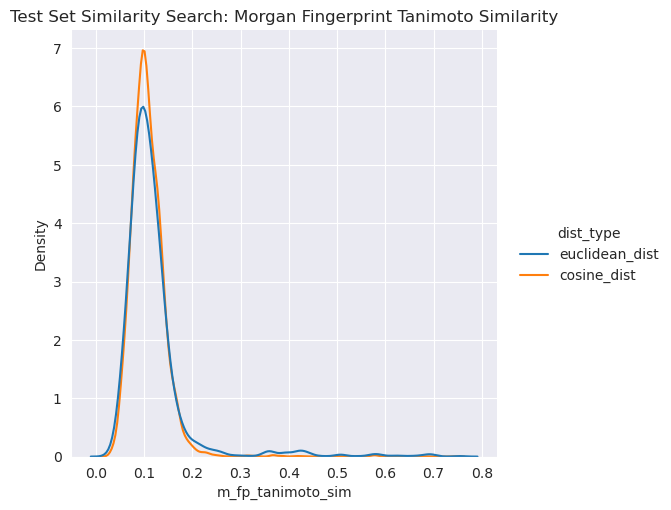

In [269]:
sns.set_style('darkgrid')
sns.displot(tmp3_df,x = 'm_fp_tanimoto_sim',  hue="dist_type", kind = 'kde')

plt.title('Test Set Similarity Search: Morgan Fingerprint Tanimoto Similarity')

plt.savefig('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/test_set_similarity_search/sim_search_m_fp_sim.png', bbox_inches="tight")

In [270]:
tmp3_df

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,0.098214,0.472222,0.627219,euclidean_dist
1,0.092437,0.567568,0.494118,euclidean_dist
2,0.110092,0.460526,0.237668,euclidean_dist
3,0.180952,0.578313,0.796875,euclidean_dist
4,0.113402,0.654545,0.685484,euclidean_dist
...,...,...,...,...
7670,0.060345,0.455882,0.243346,cosine_dist
7671,0.060345,0.455882,0.243346,cosine_dist
7672,0.096000,0.405797,0.315113,cosine_dist
7673,0.096000,0.405797,0.315113,cosine_dist


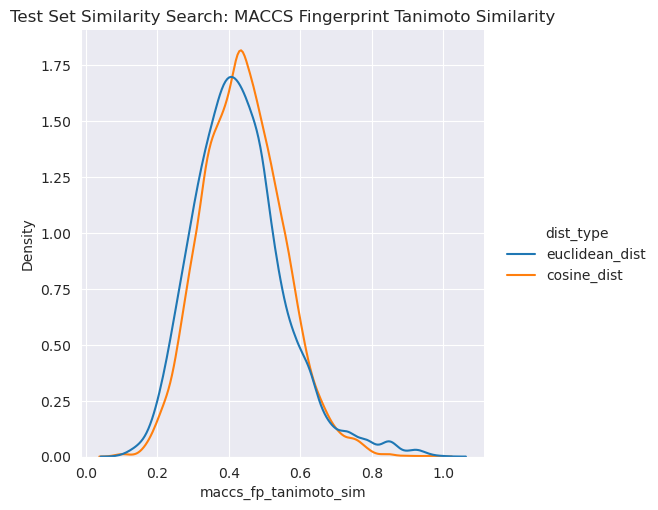

In [271]:

sns.displot(tmp3_df,x = 'maccs_fp_tanimoto_sim',  hue="dist_type", kind = 'kde')

plt.title('Test Set Similarity Search: MACCS Fingerprint Tanimoto Similarity')

plt.savefig('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/test_set_similarity_search/sim_search_maccs_fp_sim.png', bbox_inches="tight")

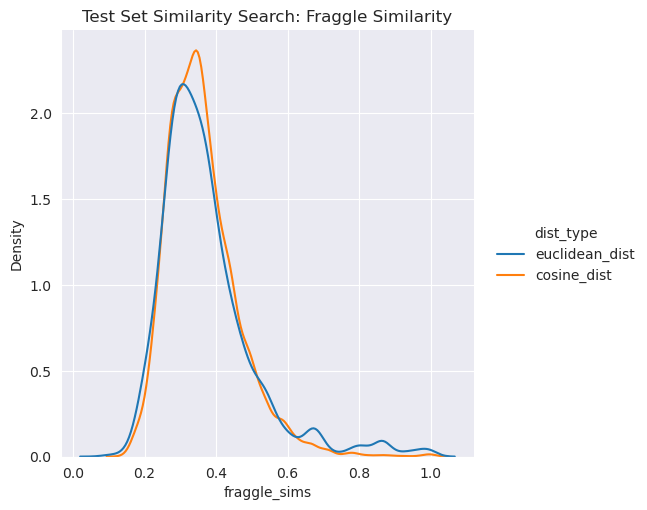

In [272]:

sns.displot(tmp3_df,x = 'fraggle_sims',  hue="dist_type", kind = 'kde')

plt.title('Test Set Similarity Search: Fraggle Similarity')

plt.savefig('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/test_set_similarity_search/sim_search_fraggle_sim.png', bbox_inches="tight")

# figures to make:
1. Combined kde for similarity search and the generated molecules: need to concatenate the csv with the generated molecules csv => show that on average the structural similarity of generated > similarity search
2. SA score distribution for generated molecules (mention that for similarity search it is 100% synthesizable)

In [275]:
eu_dist_candidates = []
cos_dist_candidates = []
for test_set_smile in test_set_smiles_to_train_set_diff_vector_and_distance:
    eu_dist_smile = test_set_smiles_to_train_set_diff_vector_and_distance[test_set_smile_idx]['min_euclidean_dist']['smile'].rsplit('_', 1)[0]
    eu_dist_candidates.append(eu_dist_smile)
    
    cos_dist_smile = test_set_smiles_to_train_set_diff_vector_and_distance[test_set_smile_idx]['max_cosine_sim']['smile'].rsplit('_', 1)[0]
    cos_dist_candidates.append(cos_dist_smile)
    


In [281]:
def compute_sa_score(smiles, threshold = 4.5):
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    sa_scores = [sascorer.calculateScore(mol) for mol in mols]
    pct_easily_synthesized = len([score for score in sa_scores if score <=4.5])/len(sa_scores)
    return sa_scores, pct_easily_synthesized

sa_scores, pct_easily_synthesized= compute_sa_score(eu_dist_candidates)

In [279]:
sa_scores, pct_easily_synthesized= compute_sa_score(cos_dist_candidates)

KeyboardInterrupt: 

In [282]:
pct_easily_synthesized

1.0

#### Generate molecules from model

In [283]:
from dataset import LincsDataset
from model import BaseModel
from aae import AAE
from dataset import MolerDataset, MolerData
from utils import pprint_pyg_obj
from torch_geometric.loader import DataLoader
import torch
from model_utils import get_params,transfer_trained_weights

In [284]:
vae_lower_lr = '/data/ongh0068/l1000/2023-03-11_23_33_36.921147/epoch=07-val_loss=0.60.ckpt'

params = get_params(dataset)
pretrained_model = BaseModel.load_from_checkpoint(vae_lower_lr, params = params, dataset = dataset, using_lincs = True)

In [296]:
torch.from_numpy(np.repeat(dataset._experiment_idx_to_dose[-1], (100))).float()

torch.Size([100, 1])

In [310]:
import itertools  
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem.Fraggle.FraggleSim import GetFraggleSimilarity
def generate_similar_molecules_with_gene_exp_diff(
    control_idx, 
    tumour_idx,
    original_idx,
    dataset,
    model,
    num_samples = 100,
    device = 'cuda:0'
):
    model = model.to(device = device)
    possible_pairs = np.array(list(itertools.product(control_idx, tumour_idx)))

    control_idx_batched = possible_pairs[:, 0]
    tumour_idx_batched = possible_pairs[:, 1]

    control_gene_exp_batched = dataset._gene_exp_controls[control_idx_batched]
    tumour_gene_exp_batched = dataset._gene_exp_tumour[tumour_idx_batched]
    difference_gene_exp_batched = tumour_gene_exp_batched - control_gene_exp_batched

    # Create num_samples//num_diff_vectors random vectors 
    if num_samples > difference_gene_exp_batched.shape[0]:
        num_rand_vectors_required = num_samples//difference_gene_exp_batched.shape[0]
        random_vectors = torch.randn(num_rand_vectors_required, 512, device = device)
        # repeat each gene expression difference vector in its place a number of times
        # equal to the number of random vectors using repeat_interleave
        # then repeat the random vectors batchwise so that we can align the random vectors 
        # with the gene expression differences 
        # Eg given 114 gene expression diff vectors, we will have 8 random vectors
        # then for each gene expresison vector, we want to match it with each of the 
        # 8 random vectors individually
        difference_gene_exp_batched = torch.tensor(difference_gene_exp_batched, device = device)
        difference_gene_exp_batched = torch.repeat_interleave(difference_gene_exp_batched, num_rand_vectors_required, dim = 0)
        random_vectors = random_vectors.repeat(possible_pairs.shape[0], 1)
    
    else:
        num_rand_vectors_required = num_samples
        # since number of samples is less than the number of gene expressions
        # we need to truncate the gene expressions too
        difference_gene_exp_batched = torch.tensor(difference_gene_exp_batched[:num_samples, :], device = device)
        random_vectors = torch.randn(num_rand_vectors_required, 512, device = device)

    dose_batched = torch.from_numpy(np.repeat(dataset._experiment_idx_to_dose[original_idx], (random_vectors.shape[0]))).float().to(device = device)



    conditioned_random_vectors = model.condition_on_gene_expression(
        latent_representation=random_vectors,
        gene_expressions=difference_gene_exp_batched,
        dose = dose_batched
    )

    # compute similarity score between all 1000 generated molecules and the actual molecule
    # take the max similarity score
    decoder_states = model.decode(latent_representations =conditioned_random_vectors, max_num_steps = 120)
    molecules = [decoder_state.molecule for decoder_state in decoder_states]

    return molecules

In [317]:
reference_smiles = test_set.SMILES.to_list()
control_idxes = test_set.ControlIndices.values
tumour_idxes = test_set.TumourIndices.values
original_idxes = test_set.original_idx.to_list()
from rdkit import RDLogger
lg = RDLogger.logger()

lg.setLevel(RDLogger.CRITICAL)
from tqdm import tqdm 

results = {}

for control_idx, tumour_idx, reference_smile, original_idx in tqdm(zip(control_idxes, tumour_idxes, reference_smiles, original_idxes)):
    candidate_molecules = generate_similar_molecules_with_gene_exp_diff(
        control_idx, 
        tumour_idx,
        original_idx,
        dataset,
        pretrained_model,
        num_samples = 100
    )
    results['_'.join([reference_smile, str(original_idx)])] = {}
    results['_'.join([reference_smile, str(original_idx)])]['generated_smiles']= [Chem.MolToSmiles(mol) for mol in candidate_molecules]
    results['_'.join([reference_smile, str(original_idx)])]['sa_scores']  = sa_scores
    sa_scores = [sascorer.calculateScore(mol) for mol in candidate_molecules]
    break

0it [00:00, ?it/s]RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaI

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime error on base molecule, with message:
unsupported operand type(s) for -: '_vectSt6vectorIiSaIiEE' and '_vectSt6vectorIiSaIiEE'
RDKit runtime

In [320]:
with open('generated_molecules_and_sa_scores.pkl', 'wb') as f:
    pickle.dump(results, f)

In [330]:
from l1000_evaluation_utils import compute_max_similarity


generated_mol_sims = {}
for reference_smile_original_idx in results:
    reference_smile = reference_smile.rsplit('_', 1)[0]
    max_sim = compute_max_similarity(
        candidate_molecules = [Chem.MolFromSmiles(smile) for smile in results[reference_smile_original_idx]['generated_smiles']],
        reference_smile = reference_smile,
    )
    generated_mol_sims[reference_smile_original_idx] = max_sim
    
    

In [331]:
with open('test_set_smile_to_max_sim_generated_molecule.pkl', 'wb') as f:
    pickle.dump(generated_mol_sims, f)

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_153': {'max_morgan_fp_tanimoto_sim': 0.17777777777777778,
  'max_maccs_fp_tanimoto_sim': 0.6779661016949152,
  'max_fraggle_sim': 0.7557251908396947}}

In [4]:
import pickle

with open('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/fs_vae_test_set_smile_to_max_sim_generated_molecule.pkl', 'rb') as f:
    fs_vae_data = pickle.load(f)
    
with open('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/tl_vae_test_set_smile_to_max_sim_generated_molecule2.pkl', 'rb') as f:
    tl_vae_data = pickle.load(f)    

# with open('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/fs_aae_test_set_smile_to_max_sim_generated_molecule.pkl', 'rb') as f:
#     fs_aae_data = pickle.load(f)
    
with open('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/tl_aae_test_set_smile_to_max_sim_generated_molecule2.pkl', 'rb') as f:
    tl_aae_data = pickle.load(f) 
    
with open('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/fs_wae_test_set_smile_to_max_sim_generated_molecule.pkl', 'rb') as f:
    fs_wae_data = pickle.load(f)
    
with open('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/tl_wae_test_set_smile_to_max_sim_generated_molecule2.pkl', 'rb') as f:
    tl_wae_data = pickle.load(f) 

In [6]:


def extract_sims(data):
    max_morgan_fp_tanimoto_sim = [value['max_morgan_fp_tanimoto_sim'] for value in data.values()]
    max_maccs_fp_tanimoto_sim = [value['max_maccs_fp_tanimoto_sim'] for value in data.values()]
    max_fraggle_sim = [value['max_fraggle_sim'] for value in data.values()]
    return [max_morgan_fp_tanimoto_sim,max_maccs_fp_tanimoto_sim,max_fraggle_sim]

file_to_sims = {
    "tl_vae":extract_sims(tl_vae_data),
    "fs_vae":extract_sims(fs_vae_data),
    "tl_aae":extract_sims(tl_aae_data),
    "fs_wae": extract_sims(fs_wae_data),
    "tl_wae": extract_sims(tl_wae_data),
}

for key in file_to_sims:
    file_to_sims[key].append([key for _ in range(len(file_to_sims[key][0]))])
    
    

In [10]:
import pandas as pd

ref_df = pd.read_csv('test_set_similarity_search_structural_similarities.csv')

In [12]:
dfs = []
for key in file_to_sims:
    new_df = pd.DataFrame(file_to_sims[key]).T
    new_df.columns = ref_df.columns
    dfs.append(new_df)
    


In [17]:
tgt = pd.concat(dfs + [ref_df])

In [54]:
# tl_vae_max_morgan_fp_tanimoto_sim = [value['max_morgan_fp_tanimoto_sim'] for value in tl_vae_data.values()]
# tl_vae_max_maccs_fp_tanimoto_sim = [value['max_maccs_fp_tanimoto_sim'] for value in tl_vae_data.values()]
# tl_vae_max_fraggle_sim = [value['max_fraggle_sim'] for value in tl_vae_data.values()]

# tl_aae_max_morgan_fp_tanimoto_sim = [value['max_morgan_fp_tanimoto_sim'] for value in tl_aae_data.values()]
# tl_aae_max_maccs_fp_tanimoto_sim = [value['max_maccs_fp_tanimoto_sim'] for value in tl_aae_data.values()]
# tl_aae_max_fraggle_sim = [value['max_fraggle_sim'] for value in tl_aae_data.values()]

# tl_wae_max_morgan_fp_tanimoto_sim = [value['max_morgan_fp_tanimoto_sim'] for value in tl_wae_data.values()]
# tl_wae_max_maccs_fp_tanimoto_sim = [value['max_maccs_fp_tanimoto_sim'] for value in tl_wae_data.values()]
# tl_wae_max_fraggle_sim = [value['max_fraggle_sim'] for value in tl_wae_data.values()]

In [24]:
tgt

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,0.11236,0.423729,0.318681,tl_vae
1,0.123596,0.298246,0.331325,tl_vae
2,0.170455,0.5,0.348416,tl_vae
3,0.108911,0.482143,0.296651,tl_vae
4,0.135135,0.380952,0.296053,tl_vae
...,...,...,...,...
15345,0.060345,0.455882,0.243346,cosine_dist
15346,0.060345,0.455882,0.243346,cosine_dist
15347,0.096,0.405797,0.315113,cosine_dist
15348,0.096,0.405797,0.315113,cosine_dist


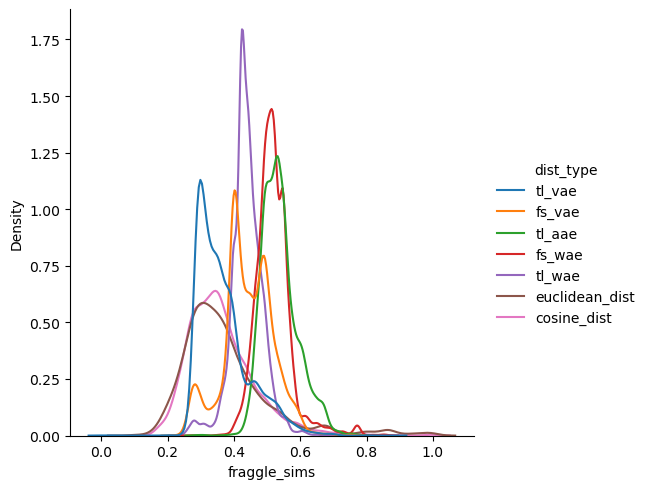

In [25]:
import seaborn as sns

sns.displot(tl_tgt,x = 'fraggle_sims',  hue="dist_type", kind = 'kde')